In [5]:
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from os.path import exists
from os.path import join as fullfile
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam

# Config the memory allocation of the gpu for gpu acceleration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


1 Physical GPUs, 1 Logical GPUs


In [16]:
def load_data():
    (trainX, trainy), (testX, testy) = mnist.load_data()
    # Reshape and Normalize grayscale img data
    trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
    testX = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)
    trainX_norm = trainX / 255.0
    testX_norm = testX / 255.0

    # One-Hot-Encode labels
    enc = OneHotEncoder(sparse=False)
    trainy_ohe = enc.fit_transform(trainy.reshape(-1,1))
    testy_ohe = enc.fit_transform(testy.reshape(-1,1))
    return trainX, trainX_norm, trainy, trainy_ohe, testX, testX_norm, testy, testy_ohe, enc

trainX, trainX_norm, trainy, trainy_ohe, testX, testX_norm, testy, testy_ohe, enc = load_data()

In [25]:
# define nn model
def generate_model():
    model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
#     model.add(MaxPooling2D((2, 2)))
    model.add(Flatten(input_shape=(28, 28, 1)))
    # rectified linear unit fxn could be replaced with many different functions 
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(10, activation='softmax'))
#     opt = SGD(learning_rate=0.01, momentum=0.9)
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# """
# maybe add dropout, experiment with avg vs max pooling, 
# try diff activation fxns, other optimizers. 
# HE initializer I think is fine 
# """

In [26]:
def evaluate_model(n_folds=5):
    foldername = 'nnMNIST_trained_adam' 
    
    if not exists(foldername):

        _, trainX_norm, trainy, trainy_ohe, _, _, _, _, enc = load_data()
        print('successful data load')
        dataX = trainX_norm
        dataY = trainy
        dataY_ohe = trainy_ohe

        scores, histories = list(), list()

        skf = StratifiedKFold(n_folds, shuffle=False)
        print('successful skf split')

        fold = 0
        for train_ix, test_ix in skf.split(np.zeros(dataY_ohe.shape[0]), dataY):
            fold += 1
            print(f'Fold {int(fold)}: \n')
            
            model = generate_model()
            print('successful model gen')

            trainX, trainY, testX, testY = dataX[train_ix], dataY_ohe[train_ix], dataX[test_ix], dataY_ohe[test_ix]
            history = model.fit(trainX, 
                                trainY, 
                                epochs=100, 
                                batch_size=32, 
                                validation_data=(testX, testY), 
                                verbose=0)

            _, acc = model.evaluate(testX, testY, verbose=0)
            print(f'Accuracy: {(acc * 100.0):2.2f}%')

            scores.append(acc)
            histories.append(history.history)

        model.save(foldername)
        
        history_dict = {'histories':histories, 'scores':scores}
        with open(fullfile(foldername, 'trainHistoryDict'), 'wb') as file_pickle:
            pickle.dump(history_dict, file_pickle)
    else:
        with open(fullfile(foldername, 'trainHistoryDict'), 'rb') as file_pickle:
            history_dict = pickle.load(file_pickle)
        scores = history_dict.get('scores')
        histories = history_dict.get('histories')
        model = tf.keras.models.load_model(foldername)        
        
    return scores, histories, model

In [27]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

scores, histories, model = evaluate_model()

successful data load
successful skf split
Fold 1: 

successful model gen
Accuracy: 96.19%
Fold 2: 

successful model gen
Accuracy: 96.02%
Fold 3: 

successful model gen
Accuracy: 96.12%
Fold 4: 

successful model gen
Accuracy: 95.81%
Fold 5: 

successful model gen
Accuracy: 96.32%
INFO:tensorflow:Assets written to: nnMNIST_trained_adam/assets


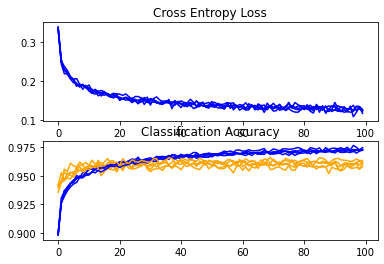

In [28]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].get('loss'), color='blue', label='Train Loss')
#         plt.plot(histories[i].get('val_loss'), color='orange', label='Validation Loss')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].get('accuracy'), color='blue', label='Train Acc')
        plt.plot(histories[i].get('val_accuracy'), color='orange', label='Validation Acc')
    
    plt.show()
    
summarize_diagnostics(histories)

In [29]:
testy_pred_ohe = model.predict(testX_norm)

testy_pred = testy_pred_ohe.argmax(axis = 1)
test_acc = mean(testy == testy_pred)
print(f'Test set accuracy: {test_acc*100:2.2f}%')

Test set accuracy: 96.34%


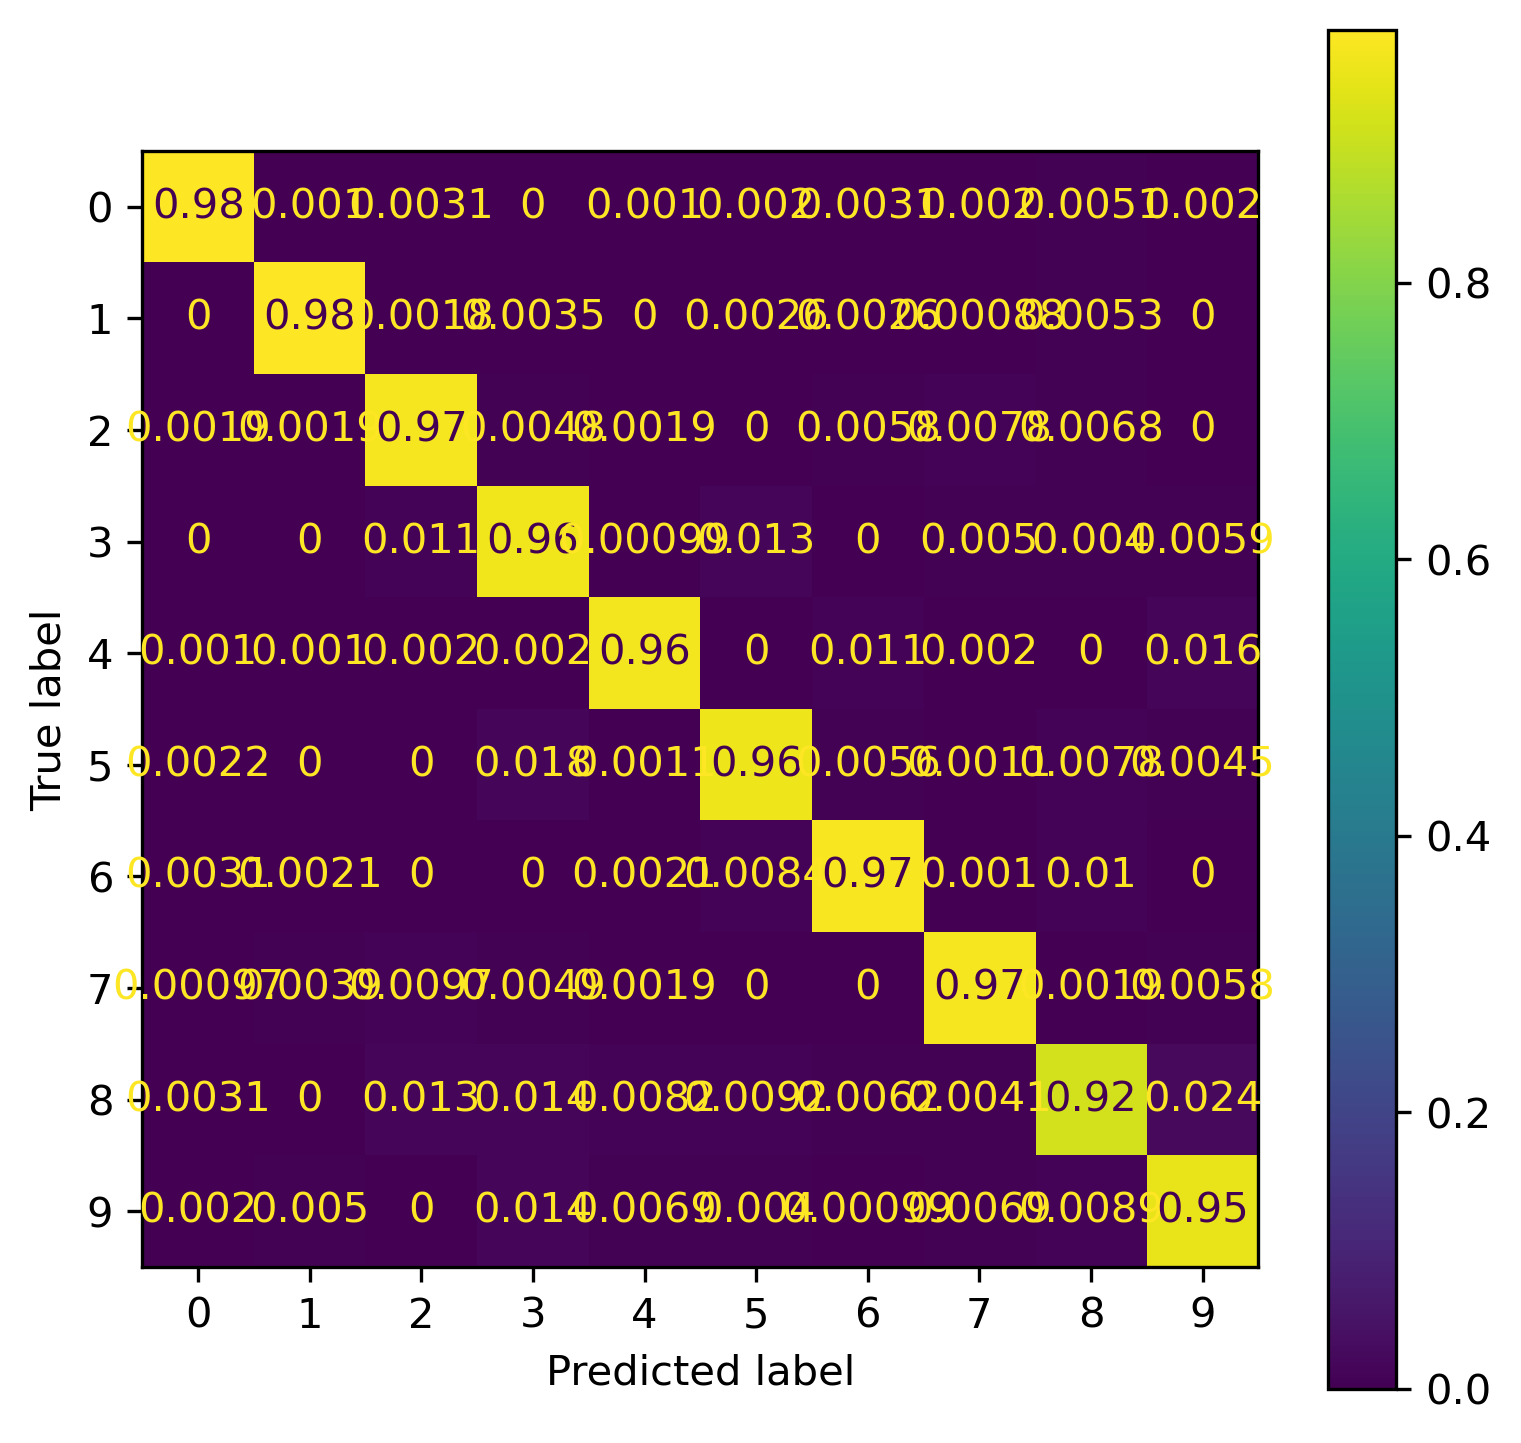

In [30]:
conf_mtx = confusion_matrix(y_true=testy, y_pred=testy_pred, normalize='true')
# conf_mtx_disp = sns.heatmap(conf_mtx, annot=True, fmt='0.3f')
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = plt.axes()
conf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx)
conf_mtx_disp.plot(ax=ax, values_format='.2g')
plt.show()

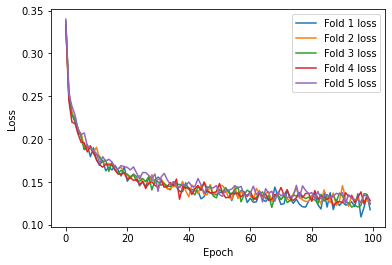

In [31]:
for i in range(len(histories)):
    fold_loss_label = f'Fold {int(i+1)} loss'
    fold_loss = plt.plot(histories[i].get('loss'), label=fold_loss_label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
